[*********************100%***********************]  1 of 1 completed

Coefficient: -0.002030703075132509
Intercept: 0.15548908547886264
R^2: 0.0008398425056659331


Price,Adj Close,Close,High,Low,Open,Volume,shift(1),Target,RSI,Predictions,Residuals
7275,436.285339,459.869995,464.739990,458.059998,461.549988,135511600,454.980011,-1.063341,53.317937,0.047216,1.110557
7276,431.646179,454.980011,455.399994,451.140015,454.480011,107134800,463.059998,1.775899,49.584774,0.054797,-1.721102
7277,439.311768,463.059998,463.209991,456.309998,458.609985,69806300,467.690002,0.999871,58.619277,0.036451,-0.963421
7278,443.704254,467.690002,467.809998,462.579987,462.790009,58890200,470.600006,0.622208,57.288581,0.039153,-0.583055
7279,446.465027,470.600006,472.190002,468.640015,468.750000,56439700,477.260010,1.415215,62.356159,0.028862,-1.386353
...,...,...,...,...,...,...,...,...,...,...,...
8256,671.929993,671.929993,675.659973,663.270020,665.380005,96846700,665.669983,-0.931646,37.998228,0.078326,1.009972
8257,665.669983,665.669983,673.710022,662.169983,669.700012,90456100,660.080017,-0.839750,32.142289,0.090218,0.929968
8258,660.080017,660.080017,665.119995,655.859985,662.099976,114467500,662.630005,0.386315,29.040705,0.096516,-0.289799
8259,662.630005,662.630005,667.340027,658.750000,660.780029,94703000,652.530029,-1.524226,35.700041,0.082993,1.607218


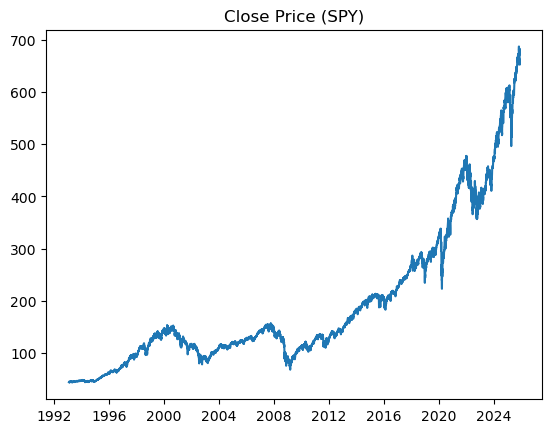

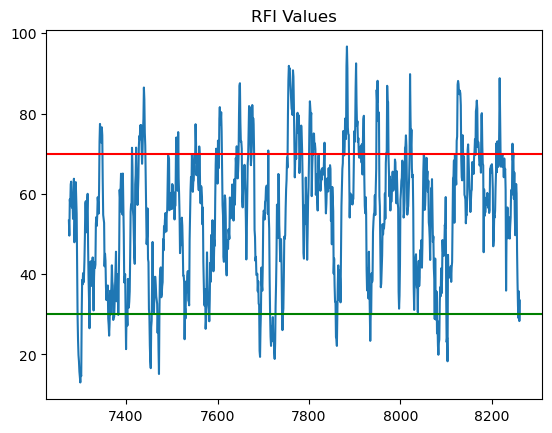

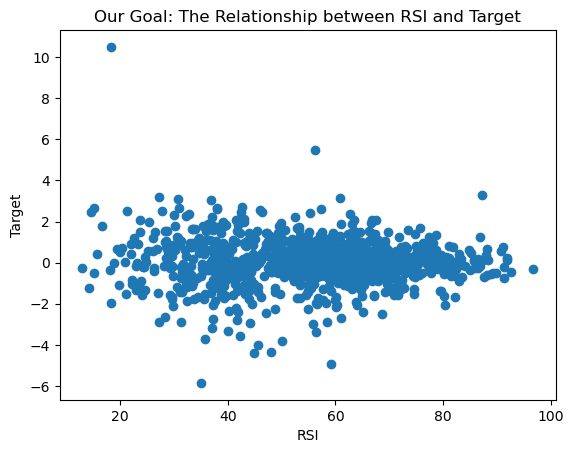

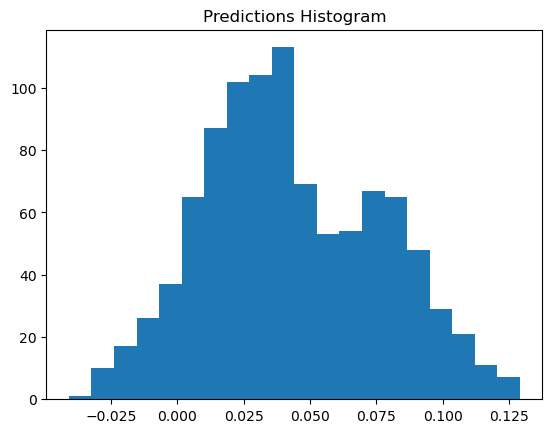

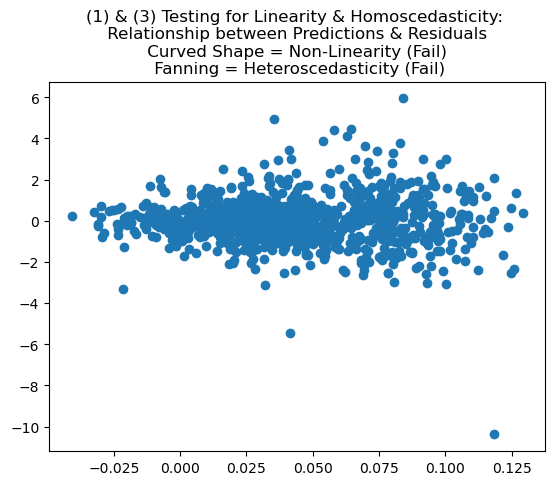

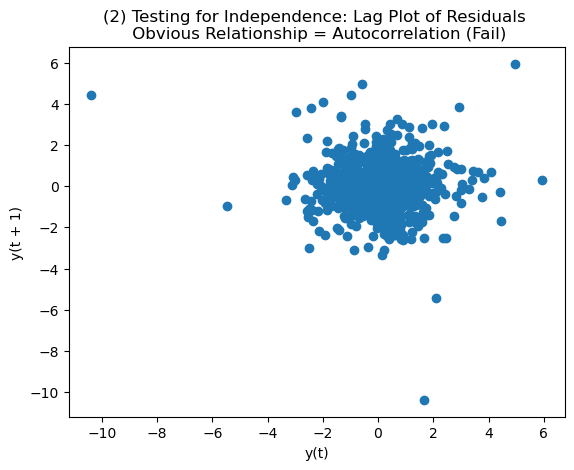

In [10]:
## Test 3 of Regression Validation - Homoscedasticity

import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
import sklearn as sk

# Step 1: Ticker
TICKER = "SPY"

# Step 2: Price Behavior 
INTERVAL = "1d"
if INTERVAL == "1h":
    PERIOD = "730d"
else:
    PERIOD = "max"

# Step 3: RSI
RSI_LENGTH = 14
RSI_OVERBROUGHT = 70
RSI_OVERSOLD = 30

# Step 3: Price difference
SHIFT = 1
    # Tomorrow's Close Price in the same Row as today

STRATEGY = "RSI"

# Step 5: Data Subsection
LOOKBACK = 1000

def get_data(ticker = TICKER, interval = INTERVAL, lookback = LOOKBACK):

    # Step 1: Download Data
    df = yf.download(ticker, interval = interval, period = PERIOD, auto_adjust=False)

    # Step 2: Select only Level 0 of Multilevel Columns
    df.columns = df.columns.get_level_values(0)
    plt.figure()
    plt.plot(df["Close"])
    plt.title(f"Close Price ({ticker})")


    # Step 3: Simplifying df for Plots
    df = df.reset_index(drop=True)

    return df.iloc[-lookback:, :]
        # -lookback: all loockback rows
        # : all columns 

# Defining y/Dependent/Target Variable
# --> We can create a strategy, that could forecast a positively/negatively correlation 
# with our Close Price changes 

def add_target(df, shift = SHIFT):

    # Step 1: How does the price change one day from now
    df[f"shift({shift})"] = df["Close"].shift(-shift)
        # shift(-1): shift backwards in time. It takes the diff value from tomorrow into the row for today
        # We are trying to find a correlation with the price of tomorrow

    # Step 2: Finding Momentum. What is the difference between Close Price today and five days from now?
    # Abolute Price Changes: 
    # df["Target"] = df[f"diff().shift({shift})"] - df["Close"]
    # Relarive Price Changes:
    df["Target"] = (df[f"shift({shift})"] - df["Close"])/df["Close"] * 100
        # Percentage Changes are very small, so we multiply it by 100

    return df

# Adding the Features/Independent Var: we want to create a Corelation between the Target and RSI 

def add_RSI(df, length = RSI_LENGTH, overbrought = RSI_OVERBROUGHT, oversold = RSI_OVERSOLD):
    
    # Step 1: Define Delta (Price changes between the Rows)
    price_change = df["Close"].diff()

    # Step 2: Group Price Changes based on Positive/Negative Returns
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # Step 3: Calculate the Rolling Average for Length Days
    avg_gain = gain.rolling(window = length).mean()
    avg_loss = loss.rolling(window = length).mean()

    # Step 4: Calculate the Relative Strength
    rs = avg_gain / avg_loss
        # In percentage Terms: how much stronger have the Up Days been compared to the Down Days
        # rs = 3: avg_gain was 3x larger than the average loss --> Strong Upward Momentum
        # rs = 0.5: avg_gain was half the size of the average loss --> Strong Downward Momentum

    # Step 5: Calculate the RSI w/ Standardization (Values between 0-100)
    df["RSI"] = 100 - (100/(1+rs))

    # Step 6: Plot the RSI
    plt.figure()
    plt.plot(df["RSI"])
    plt.title("RFI Values")

    # Step 7: Plot horizontal lines for Overbrought/Oversold
    plt.axhline(overbrought, color="red") # Crossing Overbrought Line: triggers Short Signal
    plt.axhline(oversold, color="green") # Crossing Oversold Line: triggers Long Signal
    
    return df.dropna()

# Using our Scikit Library, to understand how our RSI is related to future price movements
# --> Looking for high R^2 Values

def generate_regression_output(df, features="RSI", target="Target"):

    # Step 1: Subset Data
    subset = df[[features,target]].dropna()
        # df[[x, y]]: Selects only the columns RSI and Target from df

    # Step 2: Convert df (Pandas) into NumPy array format (Reshape for Sklearn)
    X = subset[[features]].values # 2d
        # Converts the feature column (x, e.g., 'RSI') into a NumPy array
        # [[x]]: selects the data as a DataFrame (even if it's just one column)
        # .values: extracts the data as a 2D NumPy array (e.g., [[80], [75], [70]]) - standard shape for features by sklearn
    y = subset[target].values #1d
        # [y]: selects the data as a Series
        # .values: extracts the data as a 1D NumPy array (e.g., [0.02, -0.01, 0.03]) - standard shape for the target by sklearn

    # Step 3: Model
    model = sk.linear_model.LinearRegression()
        # Creates a blank LR model object - to find the best straight line to describe the relationship between X and Y
    model.fit(X,y)
        # It feeds the model with X and Y, which adjusts the slope and y-intercept of the line, to minimizes the distance between its prediction and the true answer

    # Step 4: Use the Regression Model to predict the target variable 
    y_pred = model.predict(X)
        # It takes the trained model (the best-fit line) and feeds it your features
        # y_pred: generated array, contains the model's prediction for the target 

    # Step 5: what is the relationship between Features and Target
    r2 = sk.metrics.r2_score(y, y_pred)
        # r2: how much of the dependent variable (actual price change, y) is predictable from the features (RSI, x)
        # 1.0 (100%)Perfect Fit: Your RSI perfectly predicts the future price change. (Unlikely in trading).$
        # 0.2 (20%)Weak Fit: Your model explains 20% of the movement, and 80% is still unexplained noise.
        # 0.0 (0%)No Predictive Power: Your model is no better at predicting the outcome than simply using the historical average
        # Negative: Worse than Useless. Your model is making predictions that are actively worse than just guessing the mean.
        # In statistics, the mean (average) is the simplest possible forecast that minimizes the sum of squared errors for any dataset.

    # Step: Make Coefficient & Intercept Variable 
    coefficient = model.coef_[0]
    intercept = model.intercept_
    
    # Step 6: coef, Intercept, r2...mse later on
    print(f"Coefficient: {coefficient}")
    print(f"Intercept: {intercept}")
    print(f"R^2: {r2}")
        # Printing the Formula: Y_predi = Intercept + (Coefficient * X)
        # Coefficient: slope of the line (strength and direction of the relationship) 
        # Intercept: It's the predicted target (y) if your feature (x) were equal to zero.

    # IMPORTANT NOTE (we will do later on):
        # Verify for Homoskedasticity, before runnin a Regression Analysis
        # We assumed that, in this case, but we will prove it by using percentage change later on

    # Step 7: To better understand it, lets build a Scatter Plot
    plt.figure()
    plt.title(f"Our Goal: The Relationship between {features} and {target}")
    # Goal of the project is to see some relationship here, some patterns
    plt.scatter(X, y)
    plt.xlabel(f"{features}")
    plt.ylabel(f"{target}")
        # We want a randowm shape here and no direction anywhere

    return coefficient, intercept

# Test 1/4 & Test 3/4
def test_linearity_homoscedasticity(df, coef, intercept):

    # Step 1: Visualize Results w/ Ypred = bx + a
    df["Predictions"] = coef * df[f"{STRATEGY}"] + intercept 
    plt.figure()
    plt.hist(df["Predictions"], bins = 20)
    plt.title("Predictions Histogram")

    # Step 2: Test for both lineatity & Homoscedasticity
    df["Residuals"] = df["Predictions"] - df["Target"]
        # Synonym for Eroors: how wrong was your modell 

    # Step 3: if there is an obvious relationship between Predictions and Residuals,
    # you dont have linearity (relationship between x and y)
    plt.figure()
    plt.scatter(df["Predictions"], df["Residuals"])
    plt.title("(1) & (3) Testing for Linearity & Homoscedasticity: \n Relationship between Predictions & Residuals \n Curved Shape = Non-Linearity (Fail) \n Fanning = Heteroscedasticity (Fail)")
        # We want a randowm shape here and no direction anwhere
        # What we dont want to see is that when one gets bigger, the other also gets bigger
        # Which we see for 10000 days, so the assumption is kind of being violated

    return df

# Test 2/4
def test_independence(df):

    plt.figure()
    lag_plot(df["Residuals"].dropna())
    plt.title("(2) Testing for Independence: Lag Plot of Residuals \n Obvious Relationship = Autocorrelation (Fail)")
        # We want a randowm shape here and no direction anwhere

    return


def main():
    df = get_data()
    df = add_target(df)
    df = add_RSI(df)
    fit_coef, fit_intercept = generate_regression_output(df)
    df = test_linearity_homoscedasticity(df, coef=fit_coef, intercept=fit_intercept)
    test_independence(df)

    return df

df = main()
df